<a href="https://colab.research.google.com/github/DkMaria/Fake-News-Detection/blob/main/kge1401.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip uninstall tensorflow

In [ ]:
pip install "tensorflow>=1.15.2,<2.0"

In [ ]:
# install AmpliGraph and other dependencies

%%capture 
# Install AmpliGraph library
! pip install ampligraph

In [ ]:
#check if tensorflow is correctly installed 
import tensorflow as tf 
print(tf.version.VERSION)

1.15.5


In [ ]:
# All imports used in this notebook
%tensorflow_version 1.x
import ampligraph
import numpy as np
import pandas as pd
import pandas as pd
from ampligraph.datasets import load_from_csv 
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import TransE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from ampligraph.utils import create_tensorboard_visualizations 

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
# load data
true = load_from_csv('.', '/content/drive/MyDrive/results15.csv', sep=',') 
false = load_from_csv('.', '/content/drive/MyDrive/resultsf15.csv', sep = ',')

df_true = pd.DataFrame(true, columns = ['id', 'text', 'ratingName', 'author',  'headline', 'named_entities_claim', 'named_entities_article', 'keywords', 'source', 'sourceURL', 'link', 'language'])
df_false = pd.DataFrame(false, columns = ['id', 'text', 'ratingName', 'author', 'headline', 'named_entities_claim', 'named_entities_article', 'keywords', 'source', 'sourceURL', 'link', 'language'])

df_true['label'] = 0
df_false['label'] = 1

data = pd.concat([df_false, df_true])
# shuffle the dataset
data = data.sample(frac=1)

# drop data with no additional information
data = data.drop(columns= 'ratingName')
data = data.drop(columns= 'sourceURL')
data = data.drop(columns = 'link')
data.head(33)

,id,text,author,headline,named_entities_claim,named_entities_article,keywords,source,language,label
3019,http://data.gesis.org/claimskg/claim_review/22...,'Donna Shalala left me with 12 million doses' ...,Tommy Thompson,Tommy Thompson says he created enough smallpox...,"9/11 attacks,Anthony Fauci,Aventis Pasteur,Bil...","Donna Shalala,smallpox,smallpox vaccine","Federal Budget,Homeland Security,Public Health...",politifact,English,0
3513,http://data.gesis.org/claimskg/claim_review/e9...,The World Health Organization has listed being...,Unknown,Did WHO Define Being Single as a Disability?,"Assisted Reproductive Technologies,Huffington ...",World Health Organization,NaN,snopes,English,1
4750,http://data.gesis.org/claimskg/claim_review/0d...,Phil Puckett 'voted no on sending the EPA a me...,Republican Party of Virginia,Virginia GOP says Phil Puckett voted against s...,"American Electric Power,American Legislative E...",Phil Puckett,"Energy,Environment,Government regulation",politifact,English,1
6435,http://data.gesis.org/claimskg/claim_review/79...,A Twilight sequel titled Moonlight Glow is com...,Unknown,Is This a Poster for a New ‘Twilight’ Movie?,"Bella Cullen,Breaking Dawn,DeviantArt,Facebook...",NaN,"Entertainment, moonlight glow, twilight saga",snopes,English,1
8255,http://data.gesis.org/claimskg/claim_review/9d...,The modern image of Santa Claus was created by...,Unknown,Did Coca-Cola Invent the Modern Image of Santa...,"Clement Clarke Moore,Coca-Cola,Coca-Cola compa...","Coca-Cola Company,Santa Claus","christmas, coca-cola, santa claus",snopes,English,1
1809,http://data.gesis.org/claimskg/claim_review/6c...,Wisconsin was the 'first state to ban public a...,Mark Pocan,Mark Pocan says Wisconsin was the first state ...,"American Civil Liberties Union,Barack Obama,Ba...",sexual orientation,"Civil Rights,Legal Issues,Sexuality,Workers",politifact,English,0
2681,http://data.gesis.org/claimskg/claim_review/da...,Says she 'is 6th in hard dollars raised and ha...,Carly Fiorina,Carly Fiorina says her campaign has more cash ...,"Ben Carson,Carly Fiorina,Chris Christie,Donald...",NaN,Campaign Finance,politifact,English,0
6239,http://data.gesis.org/claimskg/claim_review/c5...,Bold Speech Given By Ehud Olmert about Israel ...,Unknown,Bold Speech Given By Ehud Olmert about Israel ...,"Ehud Olmert,Hezbollah,Israel,Lebanon,Ma’ariv,R...","Ehud Olmert,Israel",NaN,truthorfiction,English,1
6700,http://data.gesis.org/claimskg/claim_review/eb...,Says that in the Philippines more than a centu...,Donald Trump,Donald Trump cites dubious legend about Gen. P...,"Abdul Hamid II,About.com,California National G...","John Pershing,Philippines","Corrections and Updates,History,Military,Relig...",politifact,English,1
8031,http://data.gesis.org/claimskg/claim_review/b2...,Says 'For the first time in our state’s histor...,Gavin Newsom,Gavin Newsom makes False claim of raising LGBT...,"Bay Area Reporter,CNN,California state Senate,...",NaN,Civil Rights,politifact,English,1


In [ ]:
#knowledge graph creation
# naming entities
data['id'] =  data.id 
data['text'] = data.text 
data['author'] = data.author 
data['headline'] = data.headline 
data['named_entities_claim'] = data.named_entities_claim  
data['named_entities_article'] =  data.named_entities_article 
data['keywords'] =  data.keywords 
data['source'] = data.source 
data['language'] = data.language 
data['label'] = data.label

In [ ]:
triples = []
for _, row in data.iterrows():
    text = (row['id'], "hasText", row['text'])
    author = (row['id'], "isWrittenBy", row['author'])
    headline = (row['id'], "hasHeadline", row['headline'])
    named_entities_claim = (row['id'], "referredEntities", row["named_entities_claim"])
    keywords = (row['id'], "containKeywords", row['keywords'])
    language = (row['id'], "isWrittenIn", row['language'])
    source = (row['id'], "isLocated", row['source'])
    label = (row['id'], "isLabelled", row['label'])

    triples.extend((text, author, headline, named_entities_claim, keywords, language, source, label))


In [ ]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df.head(33)

,subject,predicate,object
0,http://data.gesis.org/claimskg/claim_review/5f...,hasText,If voters are turned away from polls on electi...
1,http://data.gesis.org/claimskg/claim_review/5f...,isWrittenBy,Unknown
2,http://data.gesis.org/claimskg/claim_review/5f...,hasHeadline,Can Voters Ask for Provisional Ballots If They...
3,http://data.gesis.org/claimskg/claim_review/5f...,referredEntities,"2018 election,2018 midterm elections,Brian Kem..."
4,http://data.gesis.org/claimskg/claim_review/5f...,containKeywords,"2018 election, voter purge"
5,http://data.gesis.org/claimskg/claim_review/5f...,isWrittenIn,English
6,http://data.gesis.org/claimskg/claim_review/5f...,isLocated,snopes
7,http://data.gesis.org/claimskg/claim_review/5f...,isLabelled,0
8,http://data.gesis.org/claimskg/claim_review/89...,hasText,Someone is sending sponges carrying a deadly “...
9,http://data.gesis.org/claimskg/claim_review/89...,isWrittenBy,Unknown


In [ ]:
# split triples to train-test set

#X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=10000)
 
# get the validation set of size 500
test_train, X_valid = train_test_split_no_unseen(np.array(triples), 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, test_size=10000, seed=0)

#t_size = int(len(triples) * 0.20)
#print(t_size)
#X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=t_size)



In [ ]:
print('Train set size: ', X_train.shape)
print('Valid set size: ', X_valid.shape)
print('Test set size: ', X_test.shape)

Train set size:  (105132, 3)
Valid set size:  (500, 3)
Test set size:  (10000, 3)


In [ ]:
model = TransE(k=150,                                                             # embedding size
               epochs=100,                                                        # Num of epochs
               batches_count= 10,                                                 # Number of batches 
               eta=1,                                                             # number of corruptions to generate during training
               loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters         
               initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},   # regularizer along with its hyperparameters
               optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
               seed= 0, verbose=True)
tf.logging.set_verbosity(tf.logging.ERROR)
model.fit(X_train)

Average TransE Loss:   0.029535: 100%|██████████| 100/100 [03:13<00:00,  1.93s/epoch]


# **EVALUATION METRICS**
1. Τo evaluate accuracy, test triples are considered positive and negative triples are derived from them. The evaluation protocol is thus impacted by the generation of negative triples, which remains to be analyzed.

2.  While evaluating (as described earlier), we generate all the corruptions (using all the unique entities in our dataset) per test triple, score and rank them. While doing so, we are not filtering the true positives - in other words, some of the corruptions may not really be corruptions and may be ground truth triples observed during training.  Training triples usually get a high score as they are "observed" by the model. Hence a test triple would get a lower rank if such triples appear in corruptions. To filter out the True Positives (after step b. and e.), one can pass all  the True Positive triples to filter_triples parameter of the evaluate_performance API. This will perform a "filtered" evaluation and return the "filtered" ranks adjusted by removing the True Positives from the corruptions.

In [ ]:
# Evaluating knowledge embeddings
print('Size of X_test:', X_test.shape)

# Append the Train, Valid and Test set to the X_filter.
''' The model has not "observed" them during training. We do so because, we would like
   to evaluate a test triple against it's corruptions and not against known facts. 
   If we know that the Validation triples and Test triples are facts (and not queries),
   we need to filter these triples out of the generated corruptions. This is the standard 
   procedure that is used to compute the metrics to compete on the leadership board.'''

X_filter = np.concatenate([X_train, X_valid], 0)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter)

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

Size of X_test: (10000, 3)
WARNING - You are attempting to use 66057 distinct entities to generate synthetic negatives in the evaluation
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set
    of entities. The size of corruption_entities depends on your domain-specific task.


/usr/local/lib/python3.7/dist-packages/ampligraph/evaluation/protocol.py:952: UserWarning: You are attempting to use 66057 distinct entities to generate synthetic negatives in the evaluation
    protocol. This may be unnecessary and will lead to a 'harder' task. Besides, it will lead to a much slower
    evaluation procedure. We recommended to set the 'corruption_entities' argument to a reasonably sized set
    of entities. The size of corruption_entities depends on your domain-specific task.
  warnings.warn(warn_msg % ent_for_corruption_size)
100%|██████████| 10000/10000 [21:01<00:00,  7.93it/s]


MRR: 0.35
MR: 2364.50
Hits@10: 0.42
Hits@3: 0.39
Hits@1: 0.29


In [ ]:
from sklearn.model_selection import train_test_split

y = data['label']
train_X, X1_test, train_y, y1_test = train_test_split(data['id'], y, test_size=0.20, random_state=42)
X1_train, X_val, y1_train, y_val = train_test_split(train_X, train_y, test_size =0.10, random_state=42)
print('Size training set: ',len(X1_train))
print('Size validation set: ', len(X_val))
print('Size test set: ', len(X1_test))

Size training set:  10406
Size validation set:  1157
Size test set:  2891


In [ ]:
data.label.value_counts(normalize=True)

1    0.691919
0    0.308081
Name: label, dtype: float64

In [ ]:
# get the embeddings for X1_train, X1_test, X_val_clf
X_train_clf = model.get_embeddings(X1_train)
X_test_clf = model.get_embeddings(X1_test)
X_val_clf = model.get_embeddings(X_val)

In [ ]:
# XGB classifier
clf_model = XGBClassifier(n_estimators=500, max_depth=5, binary="logistic")


In [ ]:
eval_set = [(X_train_clf, y1_train),(X_val_clf,y_val)]
clf_model.fit(X_train_clf,y1_train, eval_metric=['error','logloss'], eval_set=eval_set)

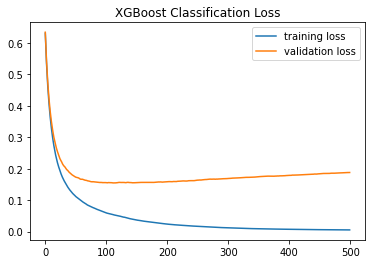

In [ ]:
from matplotlib import pyplot
# retrieve performance metrics
results = clf_model.evals_result()

# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='training loss')
pyplot.plot(results['validation_1']['logloss'], label='validation loss')
# show the legend
pyplot.legend()
pyplot.title('XGBoost Classification Loss')
# show the plot
pyplot.show()

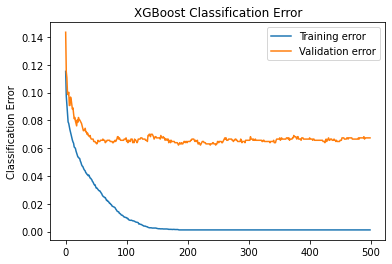

In [ ]:
# plot classification error
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Training error')
ax.plot(x_axis, results['validation_1']['error'], label='Validation error')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [ ]:
print('Classification report for TransE - XGBclassifier with label information')
target_names = ['real_news', 'fake_news']
print(classification_report(y1_test,  clf_model.predict(X_test_clf),target_names = target_names))

Classification report for TransE - XGBclassifier with label information
              precision    recall  f1-score   support

   real_news       0.93      0.86      0.89       907
   fake_news       0.94      0.97      0.95      1984

    accuracy                           0.94      2891
   macro avg       0.94      0.92      0.92      2891
weighted avg       0.94      0.94      0.94      2891



   real_news       0.93      0.86      0.89       907
['real_news', '0.93', '0.86', '0.89', '907']
[0.93, 0.86, 0.89]
   fake_news       0.94      0.97      0.95      1984
['fake_news', '0.94', '0.97', '0.95', '1984']
[0.94, 0.97, 0.95]


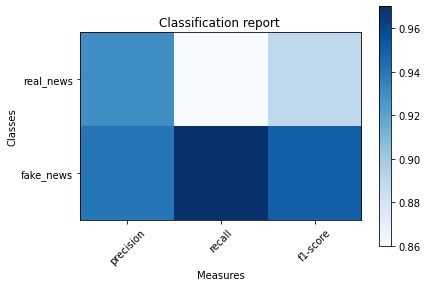

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 5)]:
        print(line)
        t = line.split()
        print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')


ClassificationReport = classification_report(y1_test, clf_model.predict(X_test_clf),target_names = target_names)
plot_classification_report(ClassificationReport)

[0]	validation_0-error:0.115318	validation_0-logloss:0.631237	validation_1-error:0.143475	validation_1-logloss:0.634351
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.097444	validation_0-logloss:0.579981	validation_1-error:0.114952	validation_1-logloss:0.585793
[2]	validation_0-error:0.091293	validation_0-logloss:0.535806	validation_1-error:0.110631	validation_1-logloss:0.542882
[3]	validation_0-error:0.086104	validation_0-logloss:0.497989	validation_1-error:0.099395	validation_1-logloss:0.508166
[4]	validation_0-error:0.078897	validation_0-logloss:0.464687	validation_1-error:0.098531	validation_1-logloss:0.476055
[5]	validation_0-error:0.07784	validation_0-logloss:0.434942	validation_1-error:0.100259	validation_1-logloss:0.448127
[6]	validation_0-error:0.075533	validation_0-logloss:0.409196	validation_1-error:0.090752	validation_1-logloss:0.423

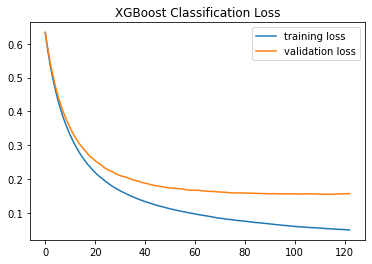

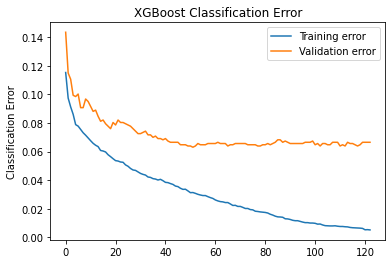

In [ ]:
'''XGBOOST -> OVERFITTING
EARLY STOPPING METHOD'''


clf_model.fit(X_train_clf,y1_train, early_stopping_rounds=10, eval_metric=['error','logloss'], eval_set=eval_set)

# retrieve performance metrics
results = clf_model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='training loss')
pyplot.plot(results['validation_1']['logloss'], label='validation loss')
# show the legend
pyplot.legend()
pyplot.title('XGBoost Classification Loss')
# show the plot
pyplot.show()

# plot classification error
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Training error')
ax.plot(x_axis, results['validation_1']['error'], label='Validation error')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

   real_news       0.93      0.85      0.89       907
['real_news', '0.93', '0.85', '0.89', '907']
[0.93, 0.85, 0.89]
   fake_news       0.94      0.97      0.95      1984
['fake_news', '0.94', '0.97', '0.95', '1984']
[0.94, 0.97, 0.95]
              precision    recall  f1-score   support

   real_news       0.93      0.85      0.89       907
   fake_news       0.94      0.97      0.95      1984

    accuracy                           0.93      2891
   macro avg       0.93      0.91      0.92      2891
weighted avg       0.93      0.93      0.93      2891



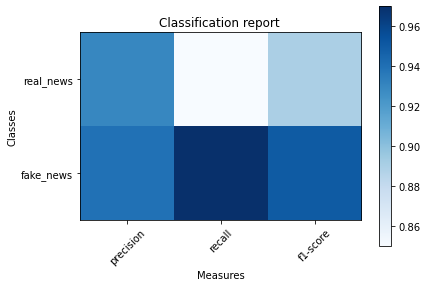

In [ ]:
ClassificationReport = classification_report(y1_test, clf_model.predict(X_test_clf),target_names = target_names)
plot_classification_report(ClassificationReport)
print(ClassificationReport)

In [ ]:
create_tensorboard_visualizations(model, 'fn_embeddings')